<h1><i><b> **Cell Nuclei Identification in Divergent Images** </b></i></h1>

___
## Executive Summary:

- **Goal:**
> Create a computer model that can identify a range of nuclei across varied conditions. By observing patterns, asking questions, and building a model, I will attempt to push state-of-the-art technology farther.
- **Why Nuclei?:**
> From Kaggle: "Identifying the cells’ nuclei is the starting point for most analyses because most of the human body’s 30 trillion cells contain a nucleus full of DNA, the genetic code that programs each cell. Identifying nuclei allows researchers to identify each individual cell in a sample, and by measuring how cells react to various treatments, the researcher can understand the underlying biological processes at work."
- **Metrics:**
> Accuracy will be evaluated on the mean average precision at different intersection over union ( IoU ) thresholds.
- **Findings:**
> So far finding that image recognition is pretty dang hard but also pretty awesome. I'm hooked.
- **Risks/limitations/assumptions for these findings:**
> One of the challenges is how much variation there is among the images. The model needs to be able to generalize well despite these differences.

    > Another particularly tough aspect is how close (and even touching) the nuclei and individual cells are. Exterior outlines may be well-defined while the nuclei may be less so.

## // Getting started with the imports that we'll need ( I think )

In [1]:
import os
import sys
import time
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import Image

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

/home/ec2-user/yes/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


> ## // Setting some parameters before we get started

In [2]:
# Downsizing the immages for now just to be able to get the workflow set up on my laptop
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './Datasets/stage1_train/'
TEST_PATH = './Datasets/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Setting seed for reproducibility
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

> ## // Getting the data

In [4]:
# Get and resize train images and masks

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')

sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:08<00:00,  9.77it/s]


In [5]:
# Now doing the same thing for the test images

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Getting and resizing test images ... ')

sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 104.17it/s]


> #### √ Checking to see if the training data looks alright √

/home/ec2-user/yes/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


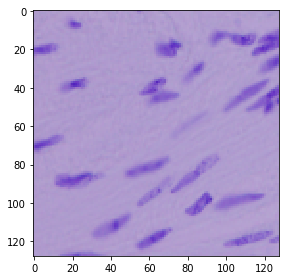

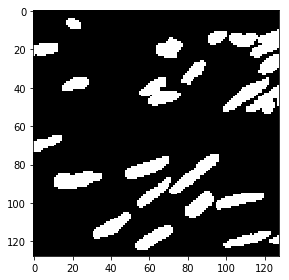

In [6]:
ix = random.randint(0, len(train_ids))

imshow(X_train[ix])
plt.show()

imshow(np.squeeze(Y_train[ix]))
plt.show()

In [7]:
# Think we're looking good there!

> ## // Creating the IoU ( Intersection Over Union) judgment metric

In [8]:
# Defining the IoU metric:

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred &gt, t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [9]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    
    iou = intersection / union

    # Precision helper function
    
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

> ## // Build and train the neural network

For the first pass through this project, I will be using a U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

![title](u-net-architecture.png)

In [10]:
from keras import backend as K
K.clear_session()

# Building U-Net model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x ) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [12]:
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=10, epochs=10)

Train on 536 samples, validate on 134 samples
Epoch 1/10
536/536 [==============================] - 13s 24ms/step - loss: 0.1326 - my_iou_metric: 0.3532 - val_loss: 0.1337 - val_my_iou_metric: 0.3364
Epoch 2/10
536/536 [==============================] - 13s 24ms/step - loss: 0.1287 - my_iou_metric: 0.3732 - val_loss: 0.1198 - val_my_iou_metric: 0.4089
Epoch 3/10
536/536 [==============================] - 13s 24ms/step - loss: 0.1134 - my_iou_metric: 0.4188 - val_loss: 0.1016 - val_my_iou_metric: 0.4676
Epoch 4/10
536/536 [==============================] - 13s 24ms/step - loss: 0.1091 - my_iou_metric: 0.4225 - val_loss: 0.0953 - val_my_iou_metric: 0.4701
Epoch 5/10
536/536 [==============================] - 13s 24ms/step - loss: 0.1015 - my_iou_metric: 0.4336 - val_loss: 0.0945 - val_my_iou_metric: 0.4919
Epoch 6/10
536/536 [==============================] - 13s 24ms/step - loss: 0.0913 - my_iou_metric: 0.4557 - val_loss: 0.0875 - val_my_iou_metric: 0.4946
Epoch 7/10
536/536 [==========

In [13]:
# Predict on train, val and test

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 7ms/step


/home/ec2-user/yes/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


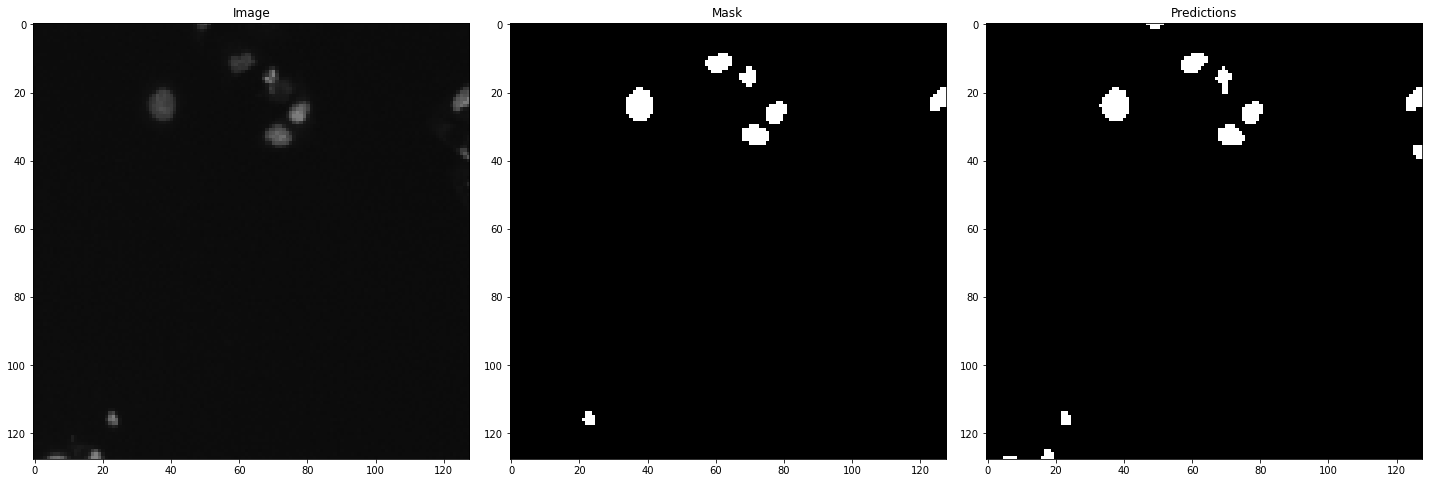

In [14]:
ix = 10
plt.figure(figsize=(20,20))

plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")

plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")

plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show();

In [15]:
iou_metric(np.squeeze(Y_train[ix]), np.squeeze(preds_train_t[ix]), print_table=True)

Thresh	TP	FP	FN	Prec.
0.500	7	4	0	0.636
0.550	7	4	0	0.636
0.600	7	4	0	0.636
0.650	7	4	0	0.636
0.700	6	5	1	0.500
0.750	6	5	1	0.500
0.800	6	5	1	0.500
0.850	6	5	1	0.500
0.900	5	6	2	0.385
0.950	3	8	4	0.200
AP	-	-	-	0.513


0.513006993006993